In [1]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from torch import optim

from torchvision import transforms
from torchvision.utils import make_grid

from typing import Dict, Tuple
from tqdm import tqdm

import imageio
from PIL import Image
import os, yaml
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 64
N_CHANNELS = 3
EPOCHS = 50
LATENT_DIM = 128
CRITIC_STEPS = 5
LAMBDA_GP = 10.0
IMG_SHAPE = (3, 128, 128)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUTPUT_IMGS_PATH = '../imgs'
GIFS_PATH = '../gifs'
MODELS_PATH = '../models'

In [3]:
with open(file="W:/faceforge/paths.yaml", mode='r') as file:
    celeba = yaml.safe_load(file)['celeba']
os.makedirs(OUTPUT_IMGS_PATH, exist_ok=True)
os.makedirs(GIFS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

In [4]:
def show_imgs(imgs: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    imgs = (imgs + 1)/2
    imgs = torch.clamp(imgs, 0, 1)
    n = imgs.shape[0]
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1], cmap='gray')
        plt.axis(False)
    plt.show()

### Dataset

In [5]:
class CelebA(Dataset):
    def __init__(self, files: dict, indices:None, transform=None):
        super(CelebA, self).__init__()
        self.attr = pd.read_csv(files['attr'])
        self.img_names = self.attr.iloc[indices, 0].reset_index(drop=True)
        
        self.img_dir = files['imgs']
        self.transform = transform
                
    def __len__(self):
        return self.img_names.shape[0]
    
    def __getitem__(self, index: int):
        img_name = self.img_names[index]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img

In [6]:
split = pd.read_csv(celeba['partition'])
train_indices = split[split['partition'] == 0].index
test_indices  = split[split['partition'] == 1].index
valid_indices = split[split['partition'] == 2].index

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=IMG_SHAPE[1:]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

trainset = CelebA(celeba, train_indices, transform=transform)
testset  = CelebA(celeba, test_indices,  transform=transform)
validset = CelebA(celeba, valid_indices, transform=transform)

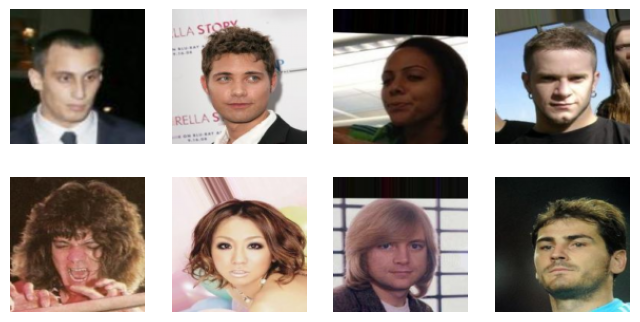

In [8]:
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = DataLoader(dataset=testset,  batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(dataset=validset, batch_size=BATCH_SIZE, shuffle=True)
imgs = next(iter(trainloader))
show_imgs(imgs[:8])

### Model

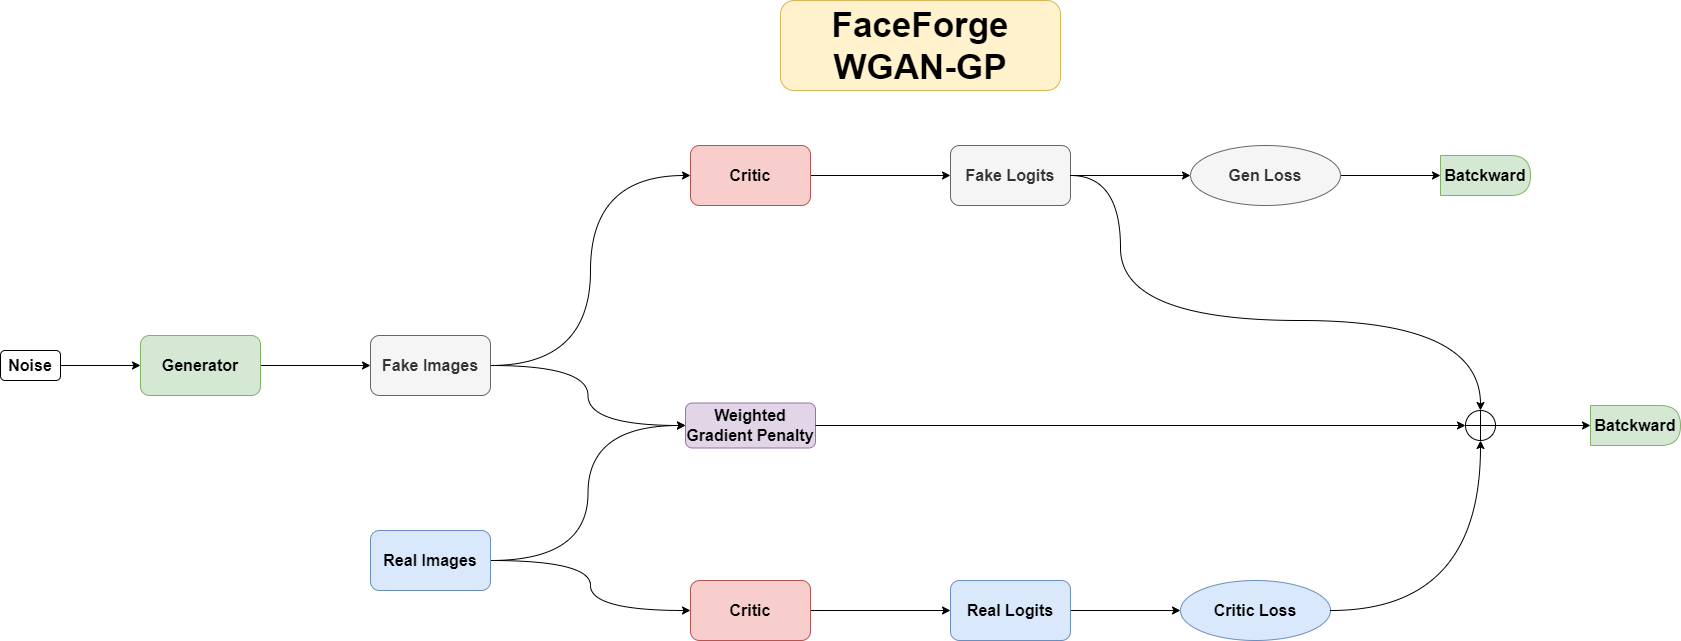

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_channels: int):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_channels = n_channels
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 2048, bias=False),
            nn.Unflatten(dim=-1, unflattened_size=(2048, 1, 1)),
            self._block(2048, 1024,  kernel_size=2, stride=1, padding=0),
            self._block(1024, 512,  kernel_size=4, stride=2, padding=1),
            self._block(512,  256,  kernel_size=4, stride=2, padding=1),
            self._block(256,  128,  kernel_size=4, stride=2, padding=1),
            self._block(128,  64,   kernel_size=4, stride=2, padding=1),
            self._block(64,   32,   kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(32, n_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def _block(self, in_channels: int, out_channels: int,
               kernel_size: int = 4, stride: int = 2, padding: int = 1,
               momentum: float = 0.9, negative_slope: float = 0.2) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 
                               kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels, momentum=momentum),
            nn.LeakyReLU(negative_slope=negative_slope))

    def forward(self, eps: torch.Tensor = None):
        eps = torch.randn((BATCH_SIZE, self.latent_dim)).to(DEVICE) if eps is None else eps
        return self.model(eps)

In [10]:
class Critic(nn.Module):
    def __init__(self, latent_dim: int, img_shape: Tuple):
        super(Critic, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            self._block(img_shape[0], 32),
            self._block(32, 64),
            self._block(64, 128),
            self._block(128, 256),
            self._block(256, 512),
            self._block(512, 1024),
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0),
            nn.Flatten())
        
    def _block(self, in_channels: int, out_channels: int, kernel_size:int=3, 
               stride:int=2, padding:int=2, negative_slope:float=0.2) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size, stride, padding),
            nn.LeakyReLU(negative_slope))
        
    def forward(self, imgs: Tensor) -> Tensor:
        return self.model(imgs)

In [11]:
class WGAN_GP(nn.Module):
    def __init__(self, generator: nn.Module, critic: nn.Module, LAMBDA_GP:float=1.0):
        super(WGAN_GP, self).__init__()
        self.generator = generator
        self.critic = critic
        self.g_optimizer = None
        self.c_optimizer = None
        self.LAMBDA_GP = LAMBDA_GP
        
    def forward(self, eps:Tensor=None) -> Tensor:
        return self.generator(eps)
    
    def compile(self, g_optimizer: Optimizer, c_optimizer: Optimizer) -> None:
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        
    def gradient_penalty(self, real_imgs:Tensor, fake_imgs:Tensor) -> Tensor:
        alpha = torch.rand((*real_imgs.shape[:1], 1, 1, 1)).to(real_imgs.device)
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.critic(interpolation)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(real_imgs.shape[0], -1)
        grad_norm = (gradients+1e-16).norm(2, dim=1)
        return (torch.clamp(grad_norm - 1., min=0, max=None) ** 2).mean()

### Model Initialization

In [12]:
print(torch.cuda.get_device_name())

generator = Generator(LATENT_DIM, N_CHANNELS)
critic    = Critic(LATENT_DIM, IMG_SHAPE)

g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.9))
c_optimizer = optim.Adam(critic.parameters(), betas=(0.5, 0.9))

model = WGAN_GP(generator, critic, LAMBDA_GP)
model.compile(g_optimizer, c_optimizer)

NVIDIA GeForce RTX 4090


### Training

In [13]:
def train_step(model: nn.Module, trainloader: DataLoader,
               device: torch.device, CRITIC_STEPS:int=3) -> Dict:
    model.train()
    
    loss = {'c_loss':.0, 'g_loss':.0, 'c_wass_loss':.0, 'c_gp':.0}
    
    for i, real_imgs in enumerate(tqdm(trainloader)):
        real_imgs = real_imgs.to(device)
        eps = torch.randn((real_imgs.shape[0], LATENT_DIM)).to(device)
                
        # ************
        # Train Critic
        # ************
        
        # setting grads to 0 after last generator backprop
        model.c_optimizer.zero_grad()
        
        # generated images with random noise
        fake_imgs = model.generator(eps)
        
        c_fake_logits = model.critic(fake_imgs)
        c_real_logits = model.critic(real_imgs)
        c_gp = model.gradient_penalty(real_imgs, fake_imgs)
        c_wass_loss = c_fake_logits.mean() - c_real_logits.mean()
        c_loss = c_wass_loss + c_gp * model.LAMBDA_GP
        
        # critic  backpropagation
        c_loss.backward()
        model.c_optimizer.step()
        
        loss['c_loss'] += c_loss.item()
        loss['c_gp'] += c_gp.item()
        loss['c_wass_loss'] += c_wass_loss.item()
        
        model.g_optimizer.zero_grad()
        
        if (i+1) % CRITIC_STEPS == 0:
            # ***************
            # Train Generator
            # ***************
            
            # generator backpropagation
            fake_imgs = model.generator(eps)
            
            c_fake_logits = model.critic(fake_imgs)
            g_loss = -torch.mean(c_fake_logits)
            
            g_loss.backward()
            model.g_optimizer.step()
            
            loss['g_loss'] += g_loss.item()
    n_batches = len(trainloader)
    for k in loss.keys():
        loss[k] /= n_batches
    loss['g_loss'] *= CRITIC_STEPS
    return loss

In [14]:
def test_step(model:nn.Module, testloader: DataLoader,
              device:torch.device) -> Dict:
    loss = {'c_loss':.0, 'g_loss':.0}
    model.eval()
    with torch.inference_mode():
        for real_imgs in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            c_real_logits = model.critic(real_imgs)
            c_loss = c_real_logits.mean()
            
            fake_imgs = model.generator()
            c_fake_logits = model.critic(fake_imgs)
            g_loss = -torch.mean(c_fake_logits)
            
            loss['c_loss'] += c_loss.item()
            loss['g_loss'] += g_loss.item()
            
        n_batches = len(testloader)
        loss['c_loss'] /= n_batches
        loss['g_loss'] /= n_batches
    
    return loss

In [15]:
def train(model: nn.Module, trainloader: DataLoader, 
          testloader: DataLoader, device: torch.device,
          EPOCHS: int, CRITIC_STEPS: int=3) -> Dict:
    model = model.to(device)
    results = {'train_loss':{'c_loss':[], 'g_loss':[], 'c_wass_loss':[], 'c_gp':[]},
               'test_loss':{'c_loss':[], 'g_loss':[]}}

    gif_rand_noise = torch.randn((64, LATENT_DIM)).to(device)
    gif_gen_imgs = []
    
    for epoch in range(1, EPOCHS+1):
        print(f"\nEPOCH ===================================> {epoch:3d}/{EPOCHS}")
        print("******************** Training ********************")
        train_results = train_step(model, trainloader, device, CRITIC_STEPS)
        print(f"Generator Loss: ------------------------> {train_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {train_results['c_loss']:.4f}")
        print(f"Critic Wasserstein Loss: ---------------> {train_results['c_wass_loss']:.4f}")
        print(f"Critic Gradient Penalty: ---------------> {train_results['c_gp']:.4f}")

        print("******************** Testing ********************")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: ------------------------> {test_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {test_results['c_loss']:.4f}")
        
        # saving results
        for k, v in train_results.items():
            results['train_loss'][k].append(v)
        for k, v in test_results.items():
            results['test_loss'][k].append(v)
        
        # gif frame generation
        model.eval()
        with torch.inference_mode():
            gen_imgs = make_grid(model(gif_rand_noise).to(device='cpu')).permute(1,2,0).numpy()
            gen_imgs = ((gen_imgs + 1) * 127.5).astype(np.uint8)
            gif_gen_imgs.append(gen_imgs)
        
        if epoch % 1 == 0:
            imageio.mimsave(f'{GIFS_PATH}/training_progress.gif',
                            gif_gen_imgs, loop=65335)
            
            imageio.imsave(f'{OUTPUT_IMGS_PATH}/{epoch}.jpg', gen_imgs)
            
            # save checkpoint
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizers_state_dict': [model.generator.state_dict(),
                                          model.critic.state_dict()], 
                'losses':results}, f"{MODELS_PATH}/faceforge.pth")
    imageio.mimsave(f'{GIFS_PATH}/training_progress.gif', gif_gen_imgs, loop=65535)
    return results

In [16]:
# results = train(model, trainloader, testloader, DEVICE, EPOCHS, CRITIC_STEPS)

### Load The Model

In [17]:
generator = Generator(LATENT_DIM, N_CHANNELS)
critic = Critic(LATENT_DIM, IMG_SHAPE)

saved_model = WGAN_GP(generator, critic)

checkpoint = torch.load("../models/faceforge.pth")
saved_model.load_state_dict(checkpoint['model_state_dict'])
results = checkpoint['losses']

### Visualization

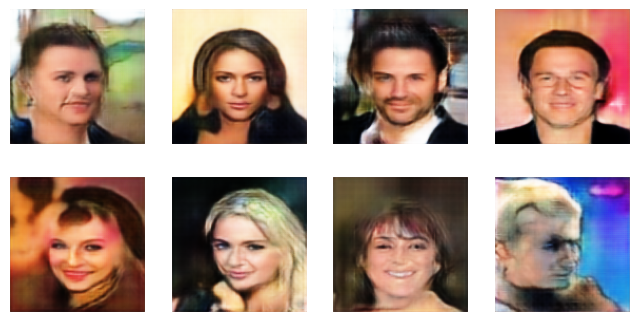

In [31]:
rand_noise =  torch.randn((8, LATENT_DIM)).to(DEVICE)
saved_model = saved_model.to(DEVICE)
saved_model.eval()
with torch.inference_mode():
    gen_imgs = saved_model(rand_noise)

show_imgs(gen_imgs)

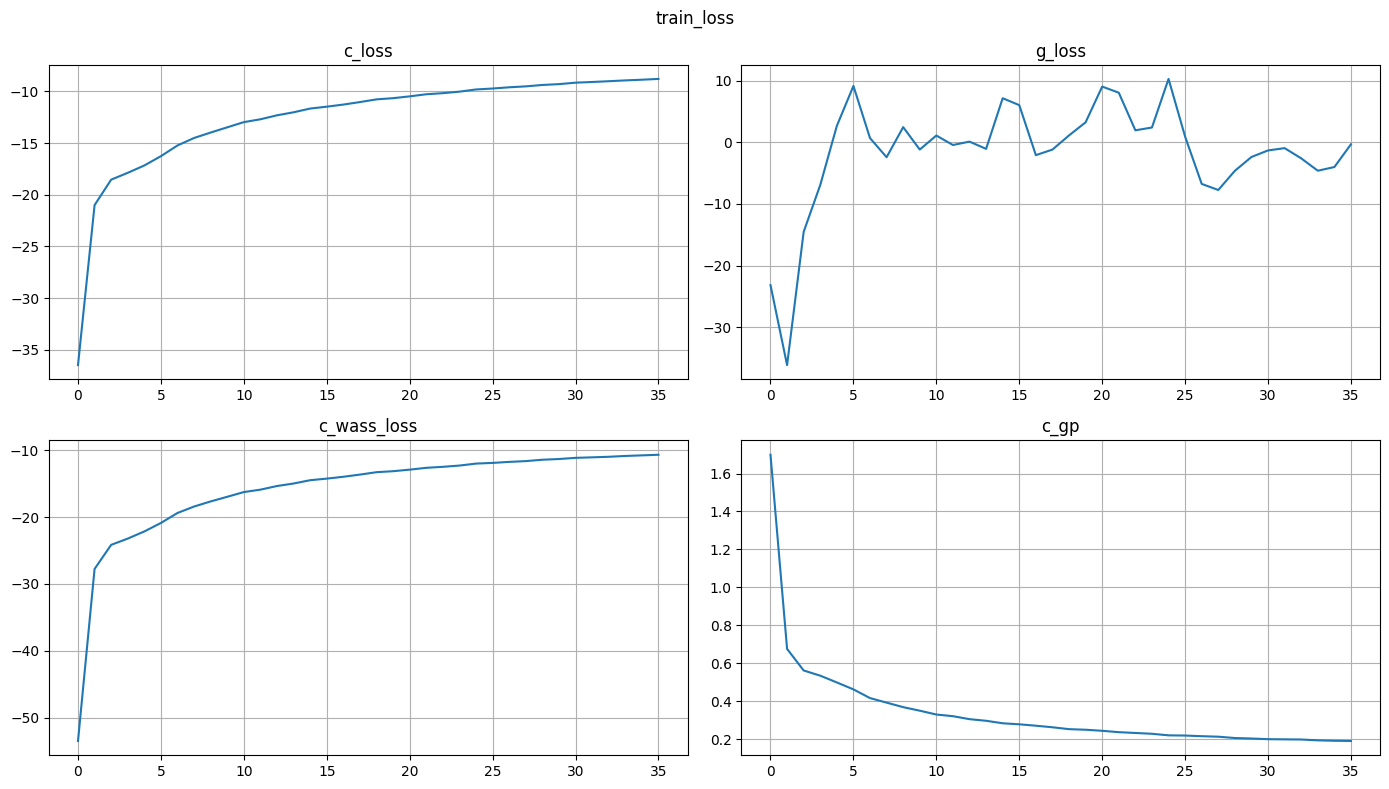

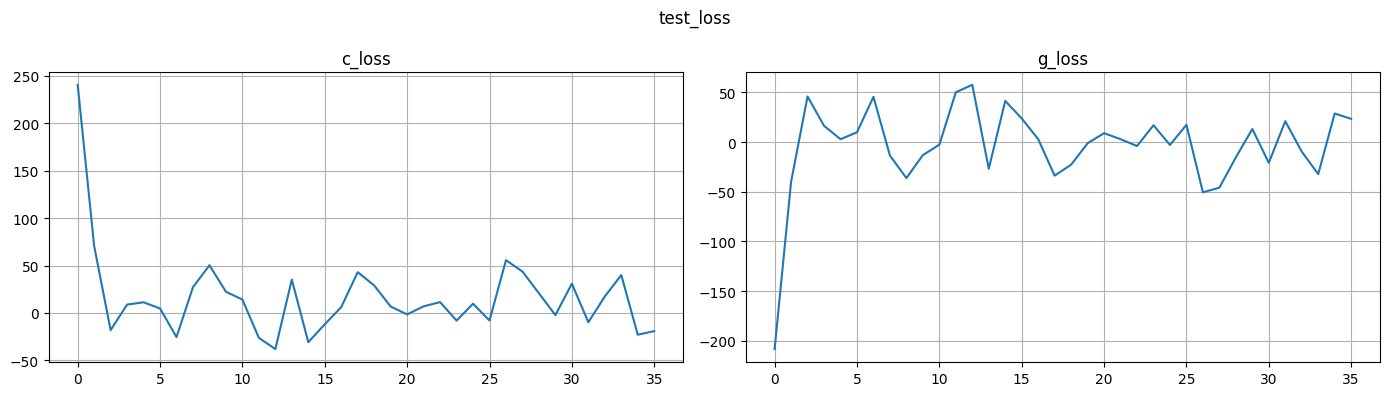

In [19]:
def plot(results:Dict, subs, title, train=True):
    section = 'train_loss' if train else 'test_loss'
    plt.subplot(int(subs))
    plt.plot(results[section][title])
    plt.title(title)
    plt.suptitle(section)
    plt.tight_layout()
    plt.grid(True)

##############
# Train Losses
##############
plt.figure(figsize=(14, 8))
plot(results, '221', 'c_loss')
plot(results, '222', 'g_loss')
plot(results, '223', 'c_wass_loss')
plot(results, '224', 'c_gp')
plt.show()

#############
# Test Losses
#############
plt.figure(figsize=(14, 4))
plot(results, '121', 'c_loss', False)
plot(results, '122', 'g_loss', False)
plt.show()